<font size = 6> Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pck
import sys 
import os
import importlib.util

spec_win = importlib.util.spec_from_file_location('lumapi', 'C:\\Program Files\\Lumerical\\v202\\api\\python\\lumapi.py')
lumapi = importlib.util.module_from_spec(spec_win)
os.add_dll_directory("C:/Program Files/Lumerical/v202/api/python")
sys.path.append(os.path.dirname('C:/Users/andre/Documents/UFCG/Photonics/Arquivos/Photonic-temperature-sensor'))
spec_win.loader.exec_module(lumapi)


In [2]:
#sensor = lumapi.MODE(filename = 'temperature_sensor.lms')
sensor = lumapi.FDTD(filename = 'temp_sensor.fsp')

In [5]:
with open('SavedData/Gap_Sweep' +'.txt', 'rb') as file: # Read .txt file
     data = pck.load(file)
file.close()

# showing data 
gapsweep = pd.DataFrame(data, columns=['gap (nm)', 'k^2', 'r^2']) 
display(gapsweep)

,gap (nm),k^2,r^2
0,200.0,0.163079,0.836921
1,250.0,0.065477,0.934523
2,300.0,0.027527,0.972473
3,350.0,0.010128,0.989872
4,400.0,0.003522,0.996478
5,450.0,0.001467,0.998533
6,500.0,0.001274,1.000502
7,550.0,0.000831,1.000141
8,600.0,0.001144,1.000656


<font size = 6>FDTD

In [6]:
# Initial Parameters
W = 500e-9
Gap = 200e-9
height = 250e-9
radius = 4e-6
accuracy = 3

sensor.switchtolayout()
sensor.selectall()
sensor.delete()

# Add substrate

sensor.addrect()
sensor.set({
    'name'                                              : 'substrate',
    'x'                                                 : 20e-6,
    'x span'                                            : 40e-6,
    'y'                                                 : 10e-6,
    'y span'                                            : 20e-6,
    'z'                                                 : -1e-6,
    'z span'                                            : 2e-6,
    'material'                                          : 'SiO2_dT',
    'override mesh order from material database'        : True,
    'mesh order'                                        : 3
})

# Ring resonator

sensor.addobject('ring_resonator')
sensor.set({
    'name'          : 'Ring',
    'material'      : 'Silicon_dT',
    'x'             : 10e-6,
    'y'             : 10e-6,
    'z'             : 0.125e-6,
    'lc'            : 0,
    'Gap'           : Gap,
    'radius'        : radius,
    'base width'    : W,
    'base height'   : height,
    'x span'        : 20e-6
})
sensor.setnamed('Ring::outer_bottom', {
    'enabled'       : False
})

# Slab

sensor.addrect()
sensor.set({
    'name'          : 'Slab',
    'x'             : 20e-6,
    'x span'        : 40e-6,
    'y'             : 10e-6,
    'y span'        : 20e-6,
    'z min'         : 0,
    'z max'         : 50e-9,
    'material'      : 'Silicon_dT'
})

# Simulation area

sensor.addfdtd()
sensor.set({
    'x'                         : 20e-6,
    'x span'                    : 13e-6,
    'y min'                     : 5.2e-6,
    'y max'                     : 16.5e-6,
    'z'                         : 0.125e-6,
    'z span'                    : 2.5e-6,
    'simulation time'           : 4000e-15,
    'simulation temperature'    : 300,
    'mesh accuracy'             : accuracy,
    'set simulation bandwidth'  : True,
    'simulation wavelength min' : 1530e-9,
    'simulation wavelength max' : 1570e-9,
    'auto shutoff min'         : 1e-4
})

# Ports
sensor.addport()
sensor.set({
    'x'                         : 14.5e-6,
    'y'                         : 10e-6 + Gap + radius + W,
    'y span'                    : 3e-6,
})
sensor.addport()
sensor.set({
    'x'                                 : 25.5e-6,
    'y'                                 : 10e-6 + Gap + radius + W,
    'y span'                            : 3e-6,
    'direction'                         : 'Backward',
})
sensor.setnamed('FDTD::ports', {
    'monitor frequency points'          : 60,
})
sensor.addmesh()
sensor.set({
    'x'                                 : 20e-6,
    'x span'                            : 4.5e-6,
    'y min'                             : 13.3e-6,
    'y max'                             : 15.3e-6,
    'z'                                 : 0.125e-6,
    'z span'                            : 0.5e-6,
    'set equivalent index'              : True,
    'equivalent x index'                : 3,
    'equivalent y index'                : 3,
    'equivalent z index'                : 3
})
# Field profile monitor
sensor.addprofile()
sensor.set({
    'name'                                  : 'profile',
    'x'                                     : 20e-6,
    'x span'                                : 13e-6,
    'y min'                                 : 5.2e-6,
    'y max'                                 : 16.5e-6,
    'z'                                     : 0.125e-6,
    'override global monitor settings'      : True,
    'frequency points'                      : 60
})

In [7]:
sensor.run()

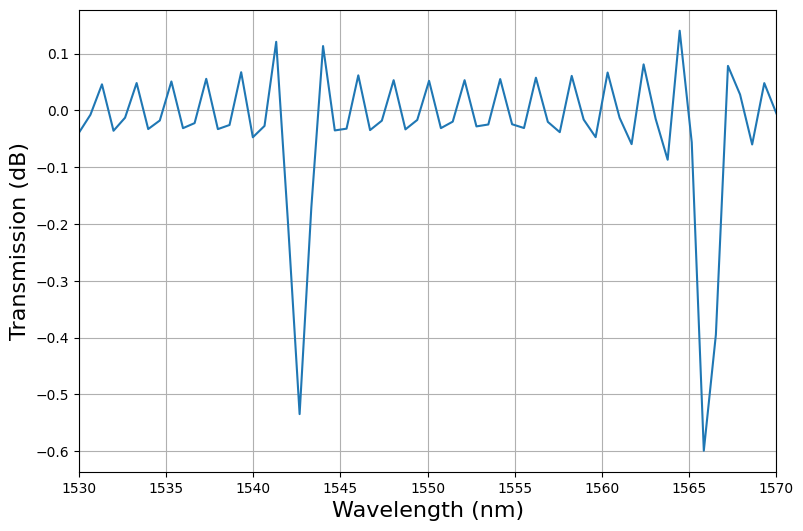

In [8]:
output = sensor.getresult('FDTD::ports::port 2', 'T')
wavelength = output['lambda']
T = output['T']

Tlog = 10*np.log10(T)

plt.figure(figsize = (9,6))
plt.plot(wavelength*1e9, Tlog)
plt.xlim(1530, 1570)
#plt.ylim(-10, 0)
plt.xlabel('Wavelength (nm)', fontsize = 16)
plt.ylabel('Transmission (dB)', fontsize = 16)
plt.grid(True)
plt.savefig('Imagens/Transmisson' + '200nm  (5)' + '.png')

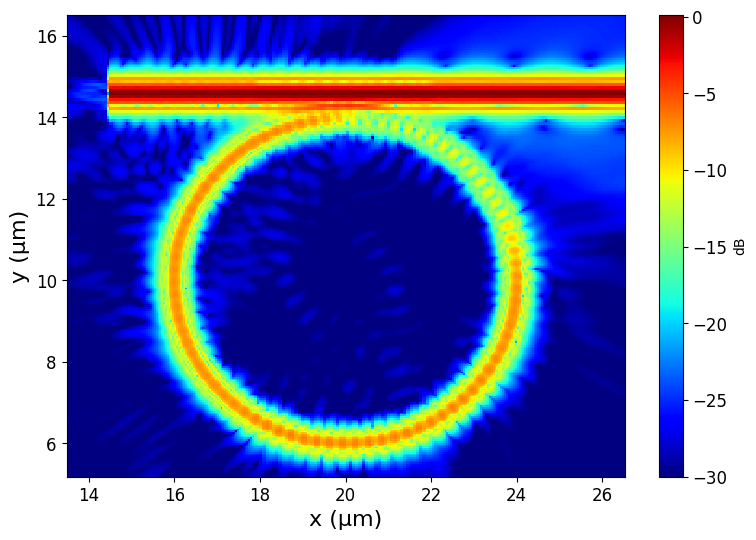

In [9]:
field_profile = sensor.getresult('profile', 'E')
x = field_profile['x']
y = field_profile['y']
E = field_profile['E']

E = np.sqrt(E[:,:,0,:,0]**2 + E[:,:,0,:,1]**2 + E[:,:,0,:,2]**2)
E = np.transpose(abs(E[:,:,0]))

Elog = 10*np.log10(E)
plt.rcParams["figure.figsize"] = (9,6)
plt.pcolormesh(x[:,0]*1e6,y[:,0]*1e6,Elog,cmap = 'jet',vmin=-30)
plt.xlabel('x (μm)',fontsize=16)
plt.ylabel('y (μm)',fontsize=16)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
cbar = plt.colorbar(label='dB')
cbar.ax.tick_params(labelsize=12)
plt.savefig('Imagens/E Log.png')